<h1 style="font-size:50px; text-align:center">DCO Detections</h1>

In [1]:
import h5py as h5
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
import seaborn as sns
import legwork
import os
import sys
sys.path.append("../src/")
from variations import variations
from galaxy import simulate_mw

In [2]:
%config InlineBackend.figure_format = 'retina'
plt.rc('font', family='serif')
fs = 20

params = {'legend.fontsize': fs,
         'axes.labelsize': fs,
         'xtick.labelsize':0.7*fs,
         'ytick.labelsize':0.7*fs}
plt.rcParams.update(params)

In [3]:
dco_colours = {"BHBH": plt.get_cmap("plasma")(0.2), 
               "BHNS": plt.get_cmap("plasma")(0.5),
               "NSNS": plt.get_cmap("plasma")(0.8)}

dco_types = ["BHBH", "BHNS", "NSNS"]
sim_folder = "../data/simulation/"  #"../data/old_sims/simulation_plus_supp/"

total_DCOs_in_MW = np.load("../data/total_DCO_in_MW.npy")
total_bound_DCOs_in_MW = np.load("../data/total_DCO_in_MW_nohubble.npy")

# Calculate number of detections

In [4]:
def get_detections(dco_type, MW_SIZE=100000, MW_MASS_FAC=1.5, t_obs=4*u.yr, only_frac=False):
    # set up arrays for return
    detections = np.zeros(shape=(len(dco_types), len(variations), 2500))
    
    # go through each physics variation
#     for d in range(len(dco_types)):
    
    for d in range(len(dco_types)):
        for v in range(len(variations)):
            # open the proper output file
            fname = sim_folder + "{}_{}_all.h5".format(dco_types[d], variations[v]["file"])
            if os.path.isfile(fname):
                with h5.File(fname, "r") as f:
                    n_ten_year = f["simulation"].attrs["n_ten_year"].astype(np.int)
                    total_mw_weight = f["simulation"].attrs["total_MW_weight"]
                    full_data = f["simulation"][...].squeeze()

                # go through the file and normalise the detections for all binaries with SNR > x
                cursor = 0
                detections_per_MW = np.zeros(len(n_ten_year))
                for i in range(len(n_ten_year)):
                    snr = full_data["snr"][cursor:cursor + n_ten_year[i]]
                    weights = full_data["weight"][cursor:cursor + n_ten_year[i]]
                    detections[d][v][i] = np.sum(weights[snr * np.sqrt(t_obs / (4 * u.yr)) > 7]) / total_mw_weight[i]
#                     detections[d][v][i] = len(snr[snr * np.sqrt(t_obs / (4 * u.yr)) > 7]) / MW_SIZE
                    cursor += n_ten_year[i]
                if not only_frac:
                    detections[d][v] *= total_DCOs_in_MW[d][v] * MW_MASS_FAC

            # set to zero if no file exists (simulation will have crashed)
            else:
                detections[d][v] = 0
    
    return detections

In [5]:
detections_4yr = get_detections(dco_types)

In [6]:
detections_10yr = get_detections(dco_types, t_obs=10*u.yr)

In [7]:
detections_only_fractions = get_detections(dco_types, only_frac=True)

In [8]:
np.save("../data/detections_4yr", detections_4yr)
np.save("../data/detections_10yr", detections_10yr)
np.save("../data/detections_only_fractions", detections_only_fractions)

# Plot number of detections

In [144]:
def plot_variations(dco_type, variations, detections,
                    dotsize=200, capwidth=0.1, error_bars=[(1, "-"), (2, "dotted")],
                    xlabel="Model Variation", ylabel="LISA Detections", shadow=False,
                    yscale="log", fig=None, ax=None, show=True):
    if fig is None or ax is None:
        fig, ax = plt.subplots(1, figsize=(15, 5))
    
    # work out mean and standard deviations
    medians = np.median(detections, axis=2)[dco_types.index(dco_type)]
    percs = np.percentile(detections, [5, 25, 75, 95], axis=2)[:, dco_types.index(dco_type), :]
    
    # plot the means as points
    xticks = np.arange(len(variations)).astype(int)
    colours = np.array([variations[v]["colour"] for v in range(len(variations))], dtype="object")
    ax.scatter(xticks, medians, s=dotsize, color=colours, zorder=5)
    
    zeros = medians == 0.0
    ax.scatter(xticks[zeros], np.repeat(medians[0], len(medians[zeros])), s=dotsize,
               color=colours[zeros], zorder=5, marker="X")
    
    for v in range(len(variations)):
        for width, style, group in [(4, "-", [1, 2]), (2, "dotted", [0, 3])]:
            for i in group:
                # plot line up to error (adjust width and style)
                ax.plot([xticks[v], xticks[v]],
                        np.sort([percs[i][v], medians[v]]),
                        color=colours[v], linewidth=width, linestyle=style)

                # plot caps on top of error bars
                ax.plot([xticks[v] - capwidth, xticks[v] + capwidth],
                        [percs[i][v], percs[i][v]],
                        color=colours[v], linewidth=width, linestyle=style)

    ax.set_xticks(xticks)
    ax.set_xticklabels([variations[v]["short"] for v in range(len(variations))])
    
    ax.set_xlim(xticks[0] - 0.5, xticks[-1] + 0.5)
    
    ax.set_yscale(yscale)
    
    xlims = ax.get_xlim()
    
    if shadow:
        ax.fill_between(xlims, means[0] - stds[0], means[0] + stds[0], color="grey", alpha=0.1, zorder=-1)
        ax.fill_between(xlims, means[0] - 2* stds[0], means[0] + 2 * stds[0], color="grey", alpha=0.1, zorder=-1)

    if xlabel is not None:
        ax.set_xlabel(xlabel, fontsize=fs)
        
    if ylabel is not None:
        ax.set_ylabel(ylabel, fontsize=fs)

    ax.tick_params(axis="both", which="major", labelsize=fs, length=10)
    ax.tick_params(axis="both", which="minor", labelsize=fs, length=5)

    ax.annotate(dco_type, xy=(0.015, 0.04), xycoords="axes fraction", fontsize=fs,
                bbox=dict(boxstyle="round", fc="white", ec="none", pad=0.0))

    ax.grid(axis="y", which="major", lw=1.5, linestyle="--")
    ax.grid(axis="y", which="minor", lw=0.3)
    
    if show:
        plt.show()
    return fig, ax

## Overall detection rate

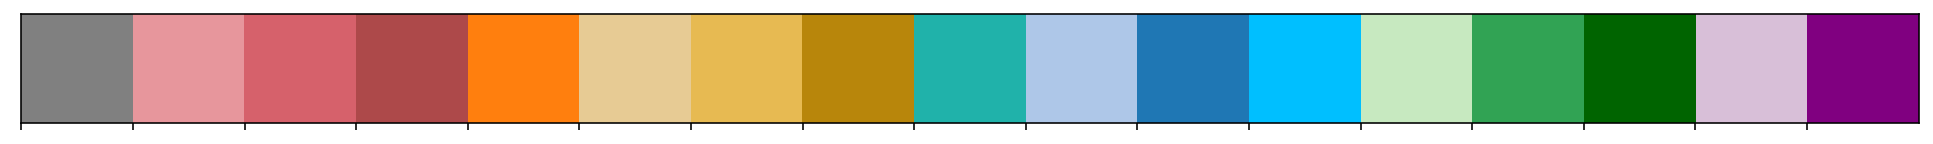

In [123]:
colours = [variations[v]["colour"] for v in range(len(variations))]
sns.palplot(colours)

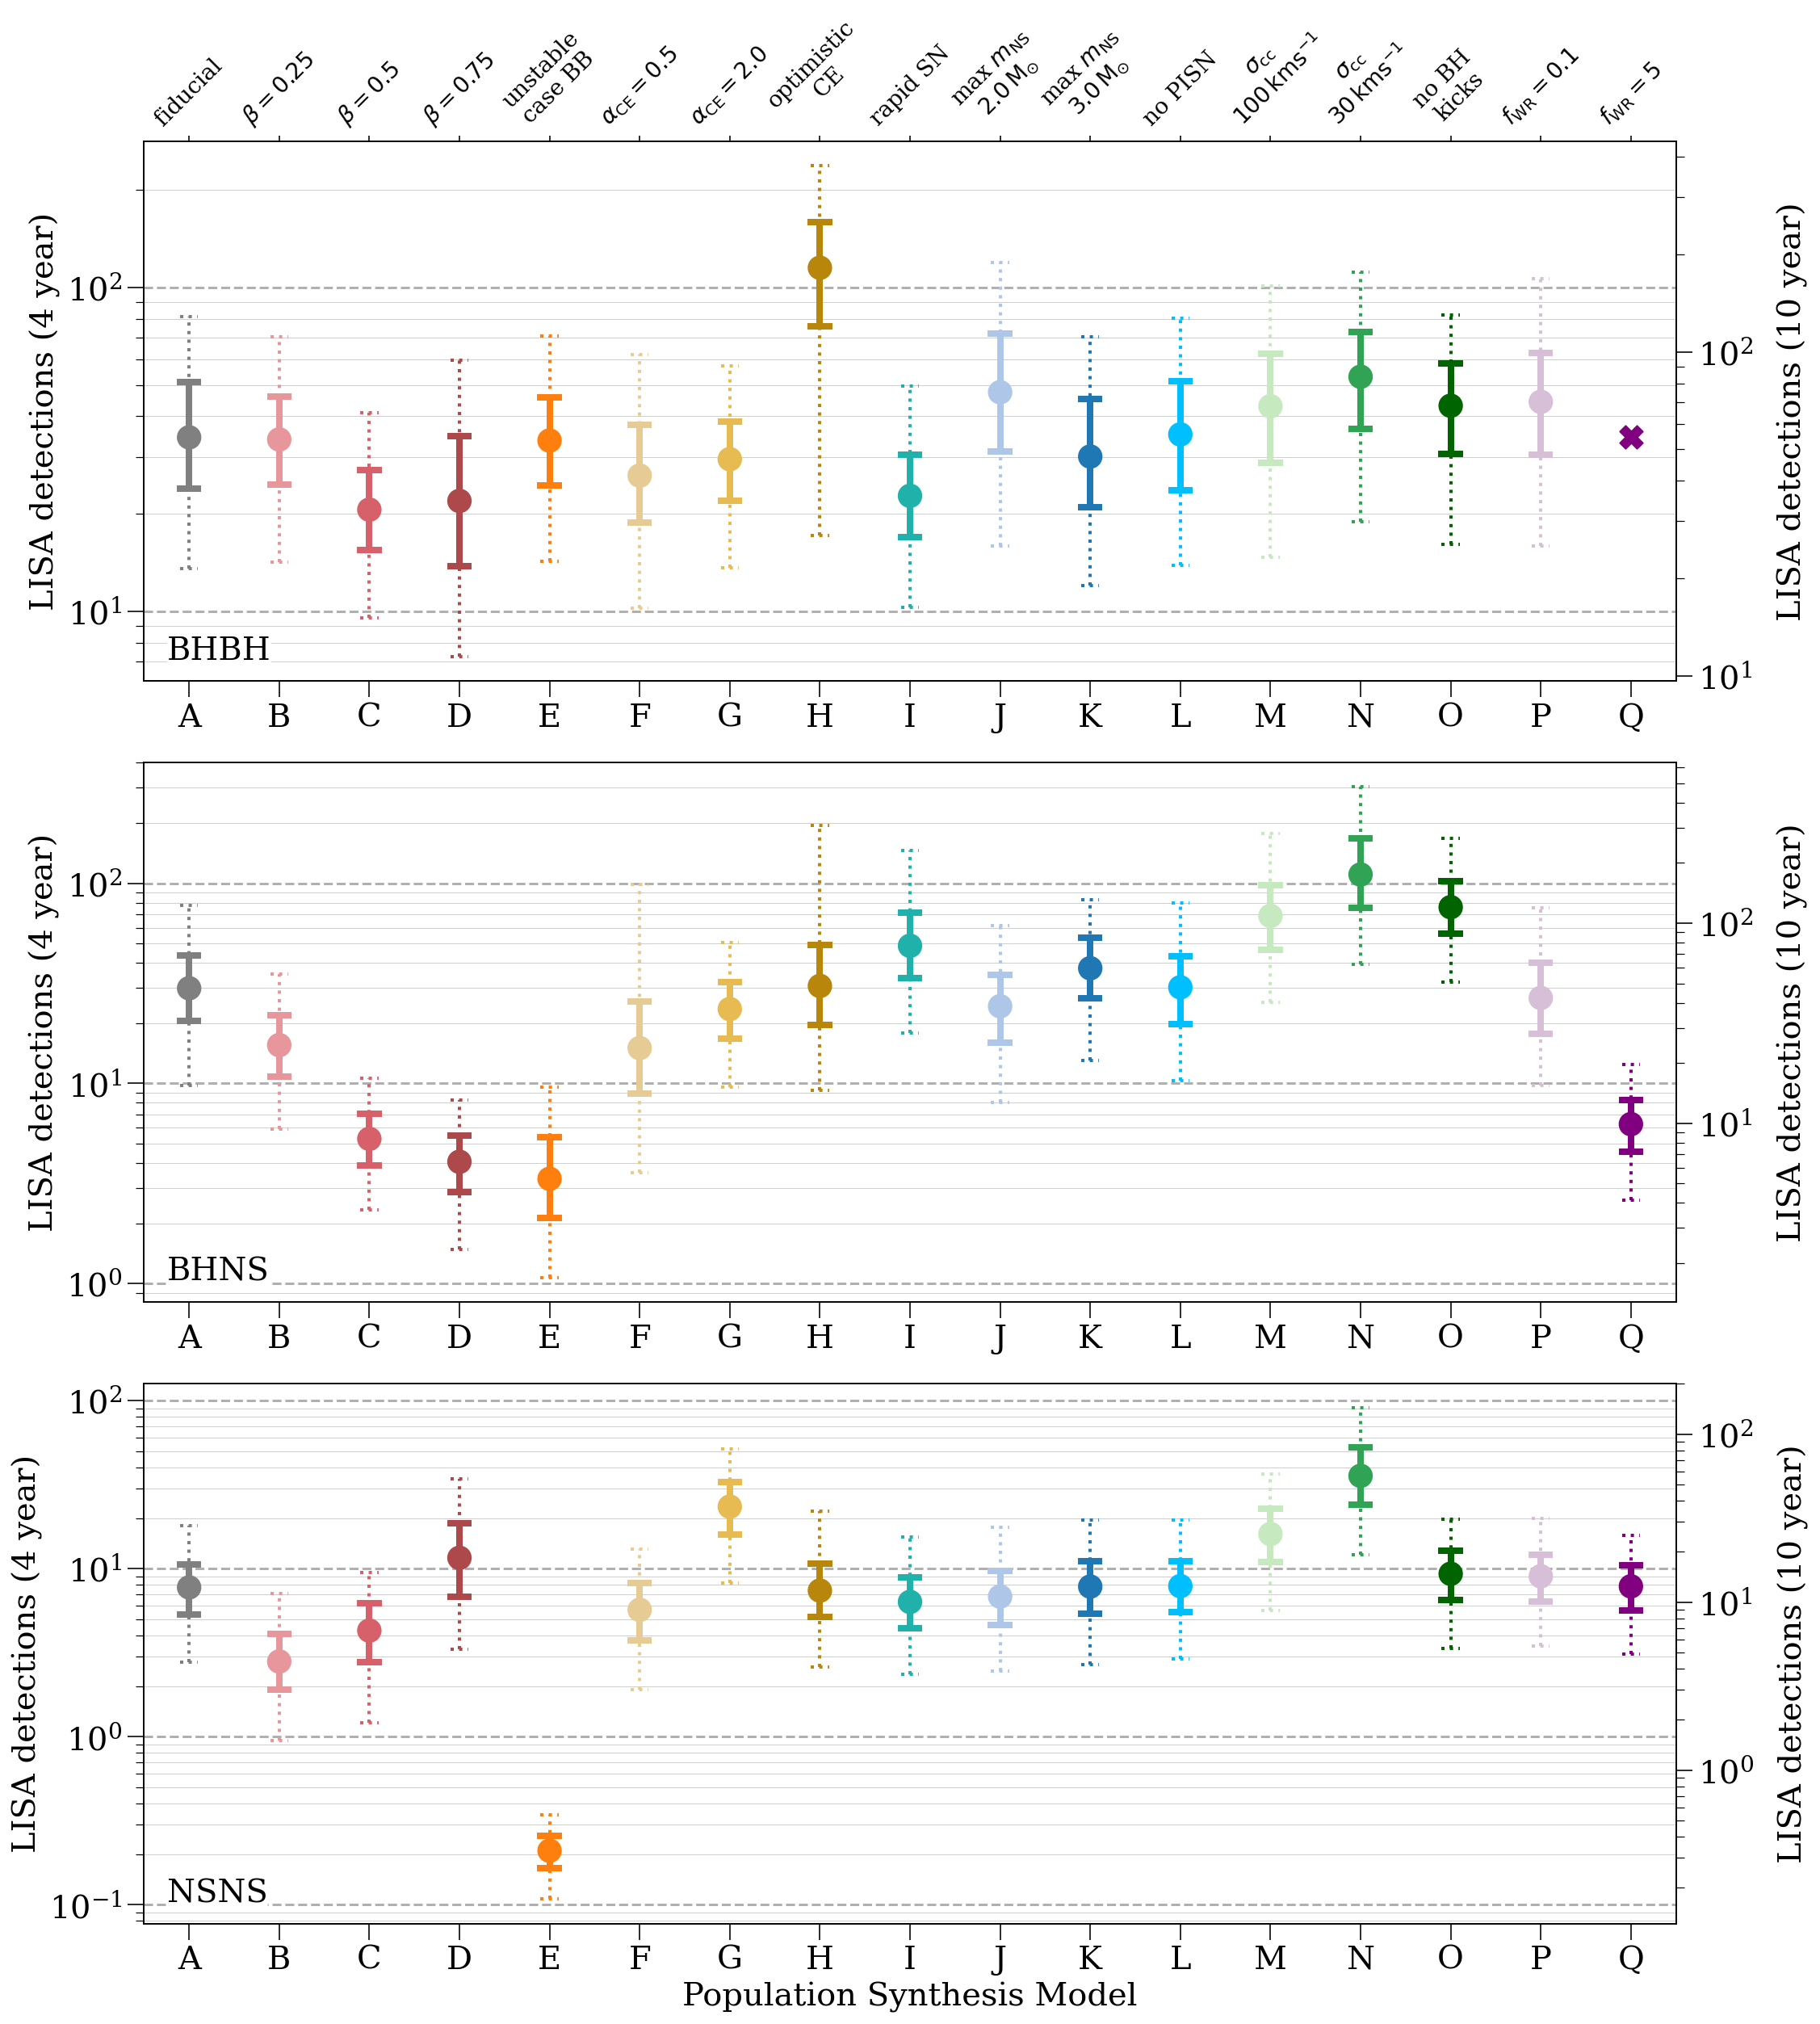

In [145]:
fig, axes = plt.subplots(3, figsize=(17, 20.3))
fig.subplots_adjust(hspace=0.15)

for ax, dco_type in zip(axes, dco_types):
    plot_variations(dco_type, variations, detections_4yr,
                    xlabel=None, ylabel="LISA detections (4 year)",
                    fig=fig, ax=ax, show=False, yscale="log")
    
    right_ax = ax.twinx()
    right_ax.set_ylim(tuple(np.array(ax.get_ylim()) * np.sqrt(10 / 4)))
    right_ax.set_yscale("log")
    right_ax.set_ylabel("LISA detections (10 year)", labelpad=15)
    right_ax.tick_params(axis="both", which="major", labelsize=fs, length=10)
    right_ax.tick_params(axis="both", which="minor", labelsize=fs, length=5)
    
top_ax = axes[0].twiny()
top_ax.set_xticks(axes[0].get_xticks())
top_ax.set_xlim(axes[0].get_xlim())
top_ax.set_xticklabels([variations[v]["med"] for v in range(len(variations))], rotation=45, fontsize=0.7*fs)

axes[-1].set_xlabel("Population Synthesis Model", fontsize=fs)

# plt.savefig("../../paper/figures/dco_detections.pdf", format="pdf", bbox_inches="tight")
    
plt.show()

## Detectable fraction

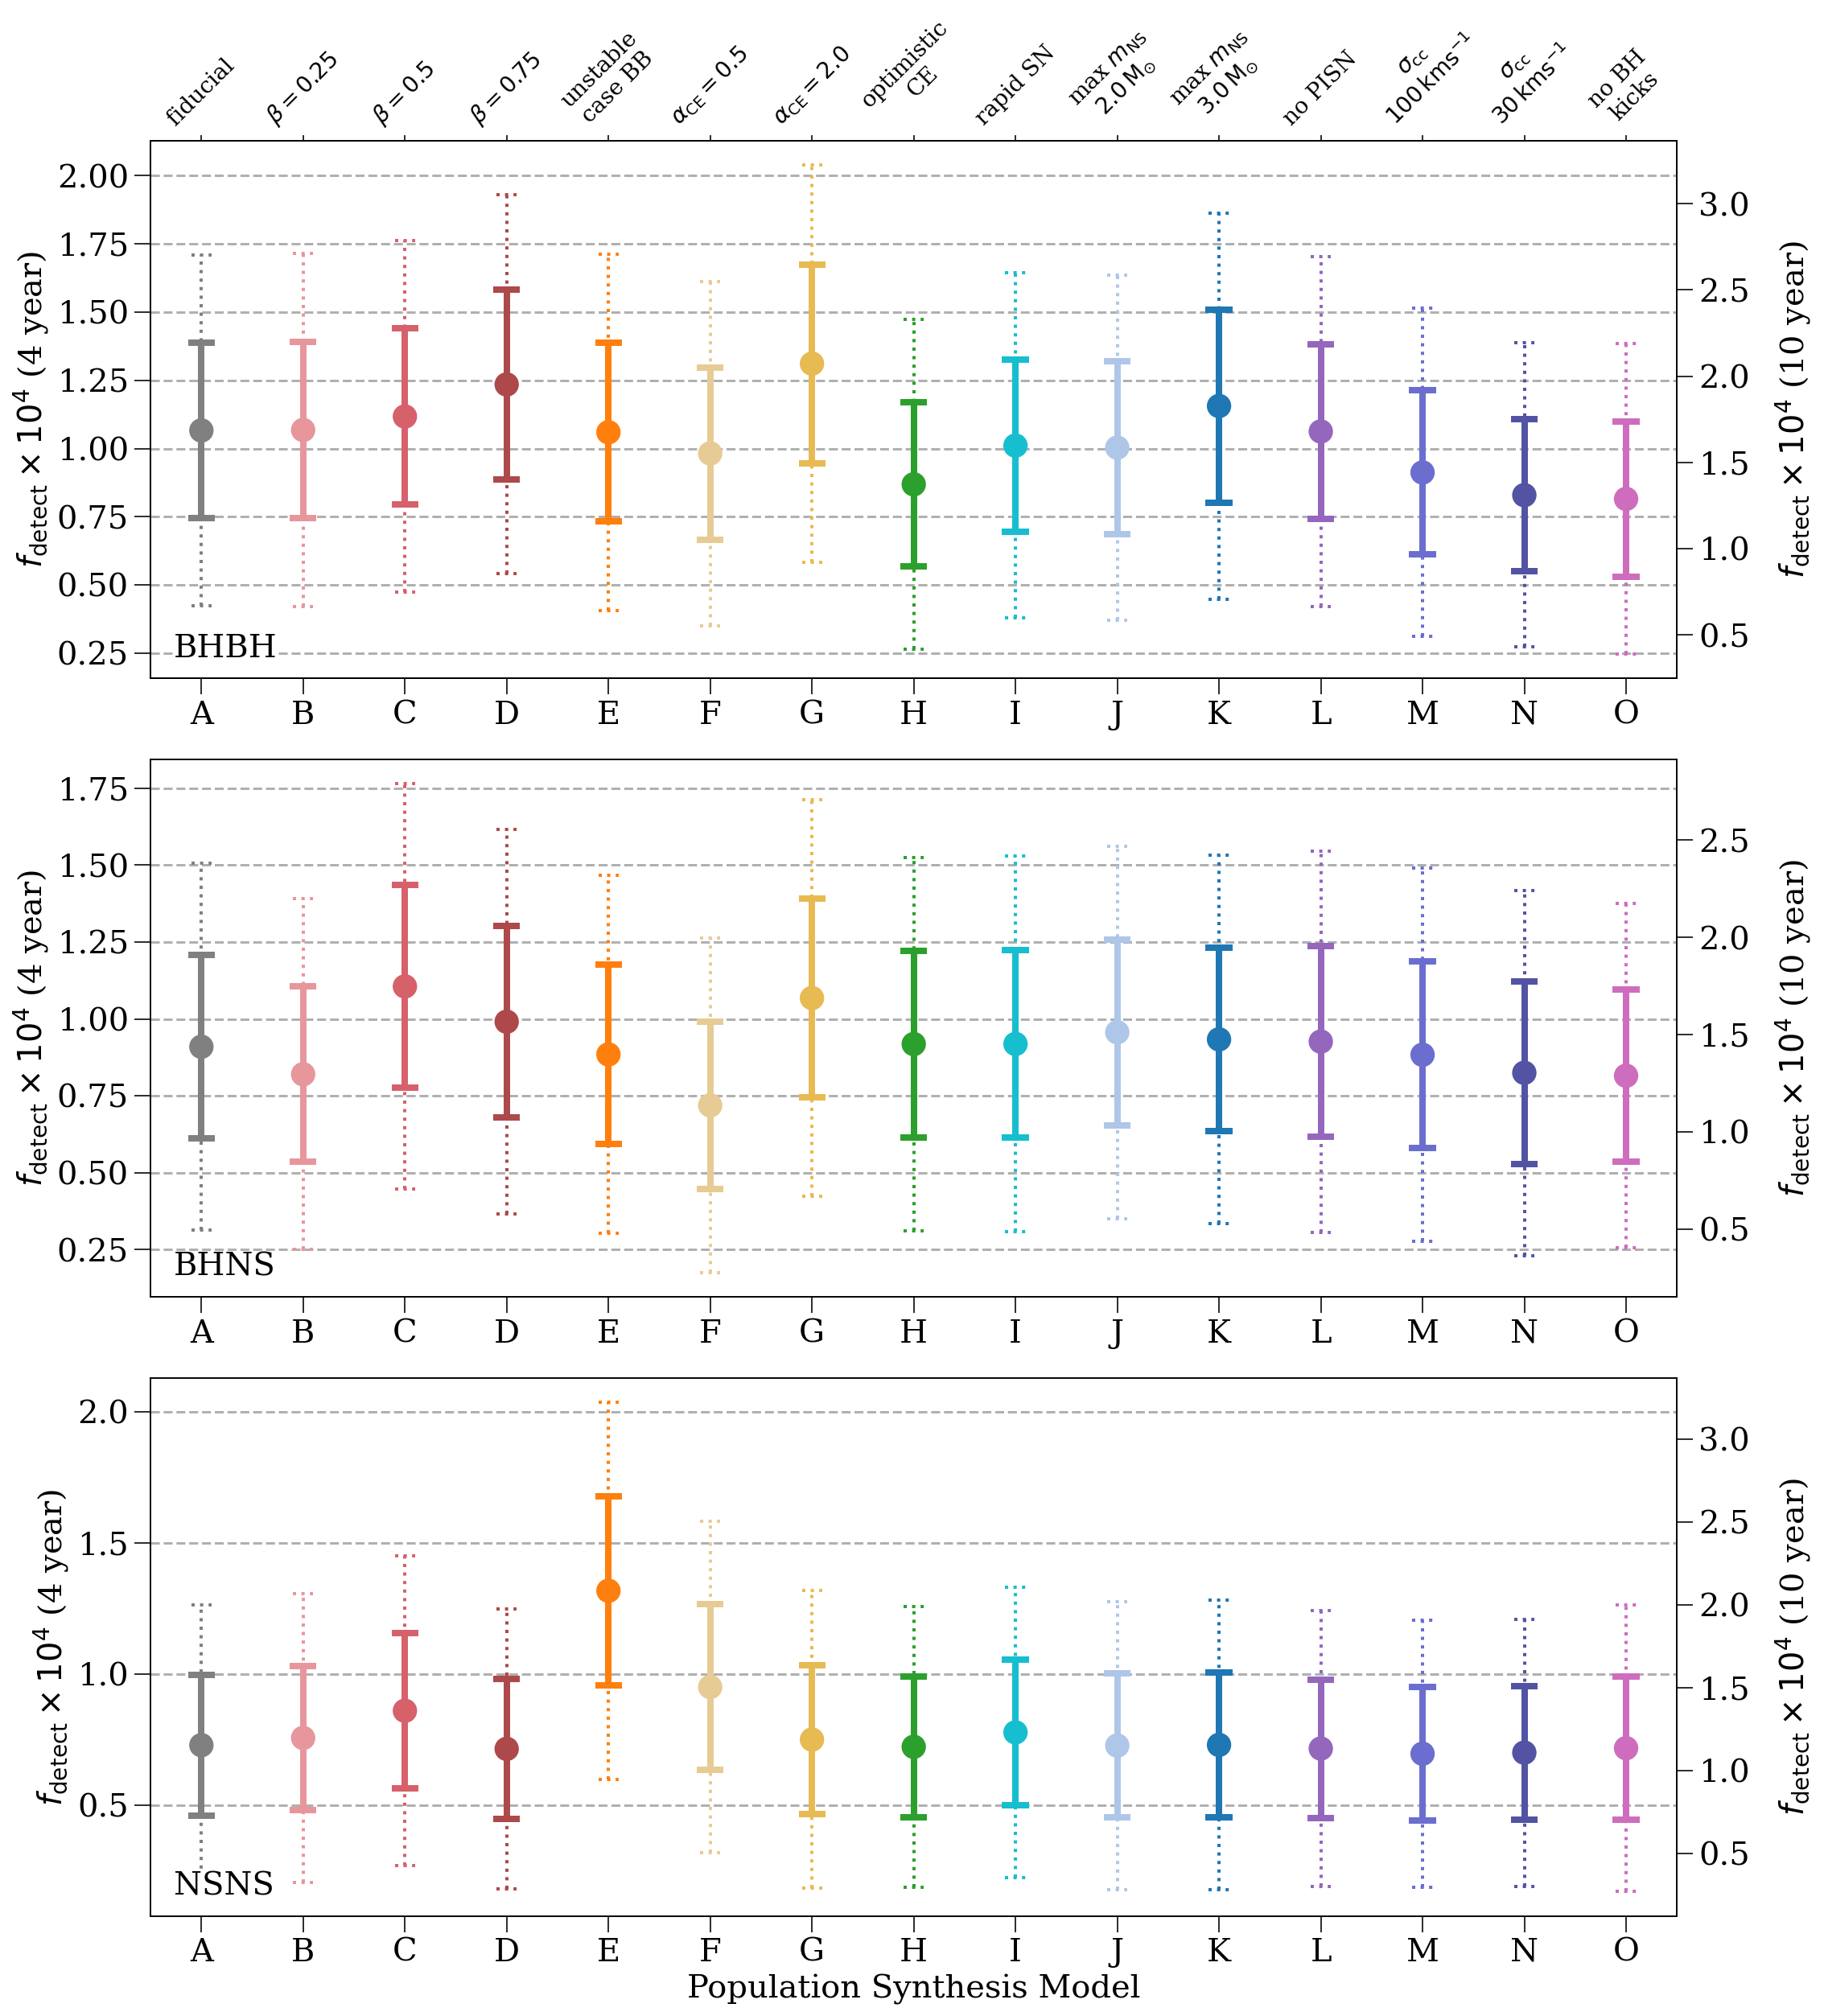

In [113]:
fig, axes = plt.subplots(3, figsize=(17, 20.3))
fig.subplots_adjust(hspace=0.15)

for ax, dco_type, col in zip(axes, dco_types, colours):
    plot_variations(dco_type, variations, detections_only_fractions * 1e4,
                    xlabel=None, ylabel=r"$f_{\rm detect} \times 10^{4}$ (4 year)",
                    yscale="linear", fig=fig, ax=ax, show=False)
    
    right_ax = ax.twinx()
    right_ax.set_ylim(tuple(np.array(ax.get_ylim()) * np.sqrt(10 / 4)))
    right_ax.set_yscale("linear")
    right_ax.set_ylabel(r"$f_{\rm detect} \times 10^{4}$ (10 year)", labelpad=15)
    right_ax.tick_params(axis="both", which="major", labelsize=fs, length=10)
    right_ax.tick_params(axis="both", which="minor", labelsize=fs, length=5)
    
top_ax = axes[0].twiny()
top_ax.set_xticks(axes[0].get_xticks())
top_ax.set_xlim(axes[0].get_xlim())
top_ax.set_xticklabels([variations[v]["med"] for v in range(len(variations))], rotation=45, fontsize=0.7*fs)

axes[-1].set_xlabel("Population Synthesis Model", fontsize=fs)

plt.savefig("../../paper/figures/dco_detections_fractions.pdf", format="pdf", bbox_inches="tight")
    
plt.show()

## Total bound DCOs

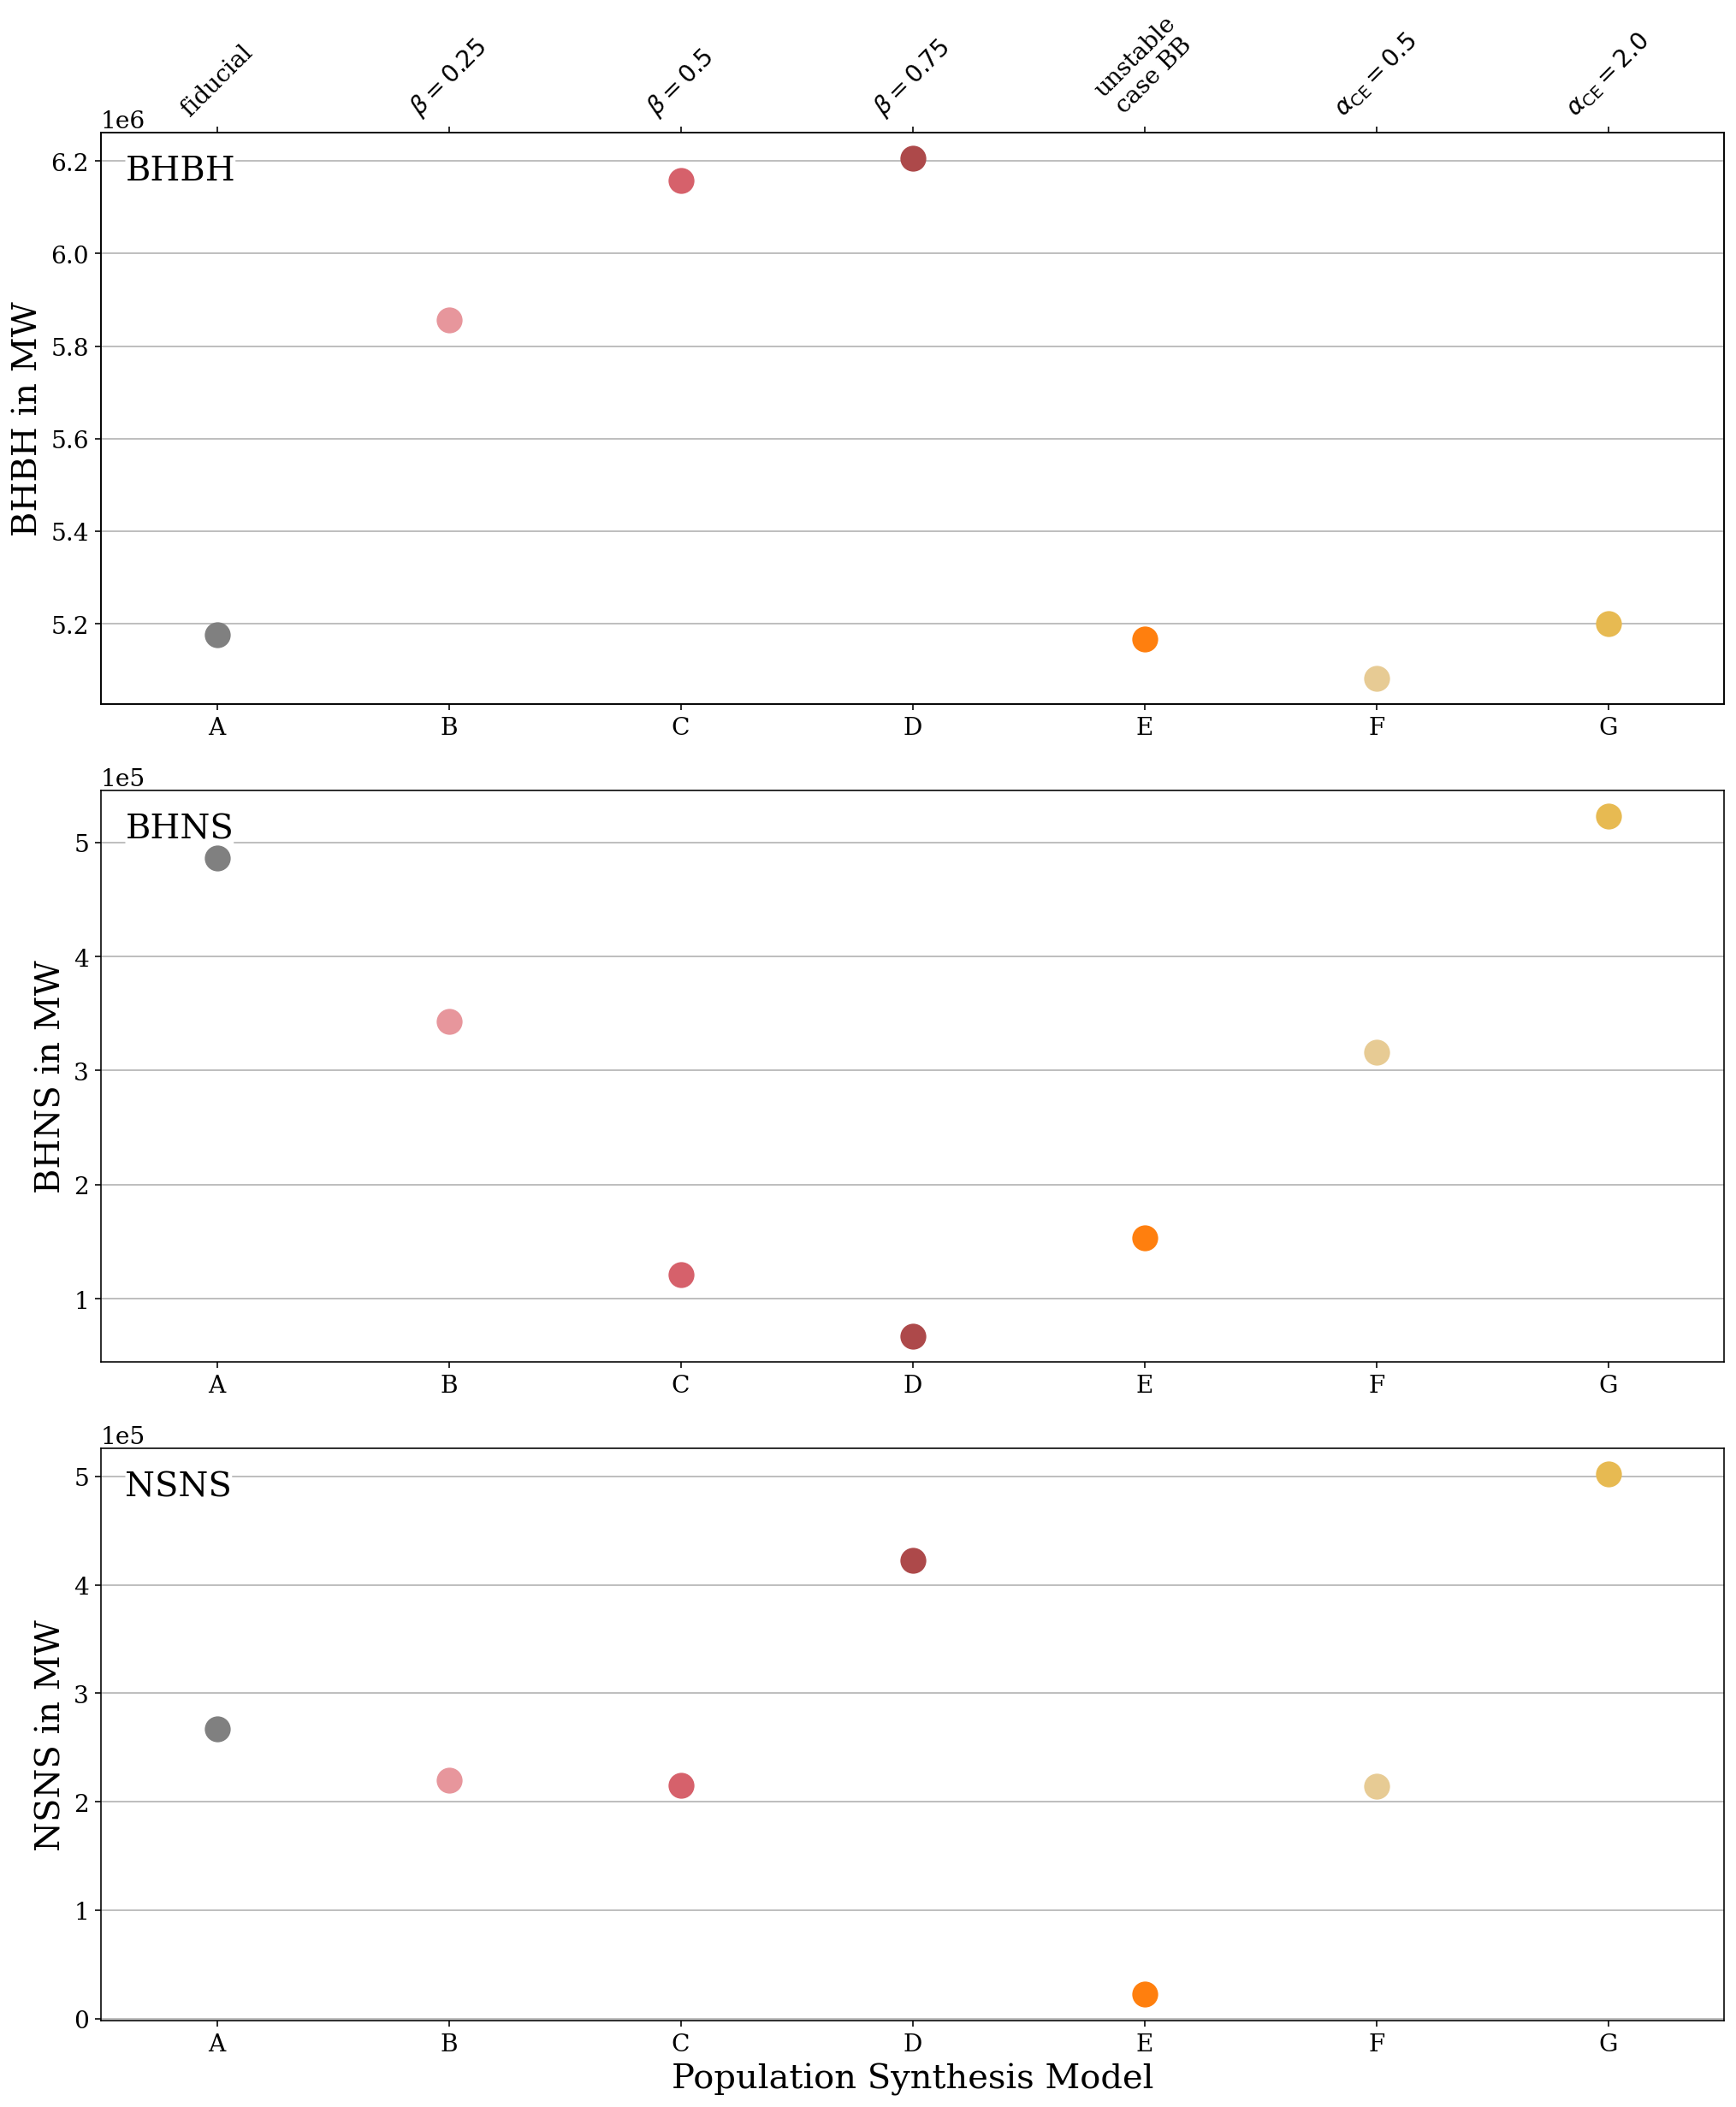

In [8]:
fig, axes = plt.subplots(3, figsize=(17, 20.3))
fig.subplots_adjust(hspace=0.15)

which_variations = [0, 1, 2, 3, 4, 5, 6]

for i in range(len(axes)):
    colours = np.array([variations[v]["colour"] for v in which_variations], dtype="object")
    
    for v in which_variations:
        axes[i].scatter(v, total_bound_DCOs_in_MW[i][v] * 1.5, color=variations[v]["colour"], s=200, zorder=10)
    
    ax = axes[i]
    
    ax.set_xticks(which_variations)
    ax.set_xticklabels([variations[v]["short"] for v in which_variations])
    ax.annotate(dco_types[i], xy=(0.015, 1 - 0.04), xycoords="axes fraction", fontsize=fs, va="top",
                bbox=dict(boxstyle="round", fc="white", ec="none", pad=0.0))

    ax.set_xlim(which_variations[0] - 0.5, which_variations[-1] + 0.5)
    ax.set_ylabel("{} in MW".format(dco_types[i]))
    
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

    ax.grid(axis="y", which="major")
    
topax = axes[0].twiny()
topax.set_xticks(axes[0].get_xticks())
topax.set_xlim(axes[0].get_xlim())
topax.set_xticklabels([variations[v]["med"] for v in which_variations], rotation=45, fontsize=0.7*fs)

axes[-1].set_xlabel("Population Synthesis Model", fontsize=fs)
    
plt.show()

## Total DCOs merging in Hubble time

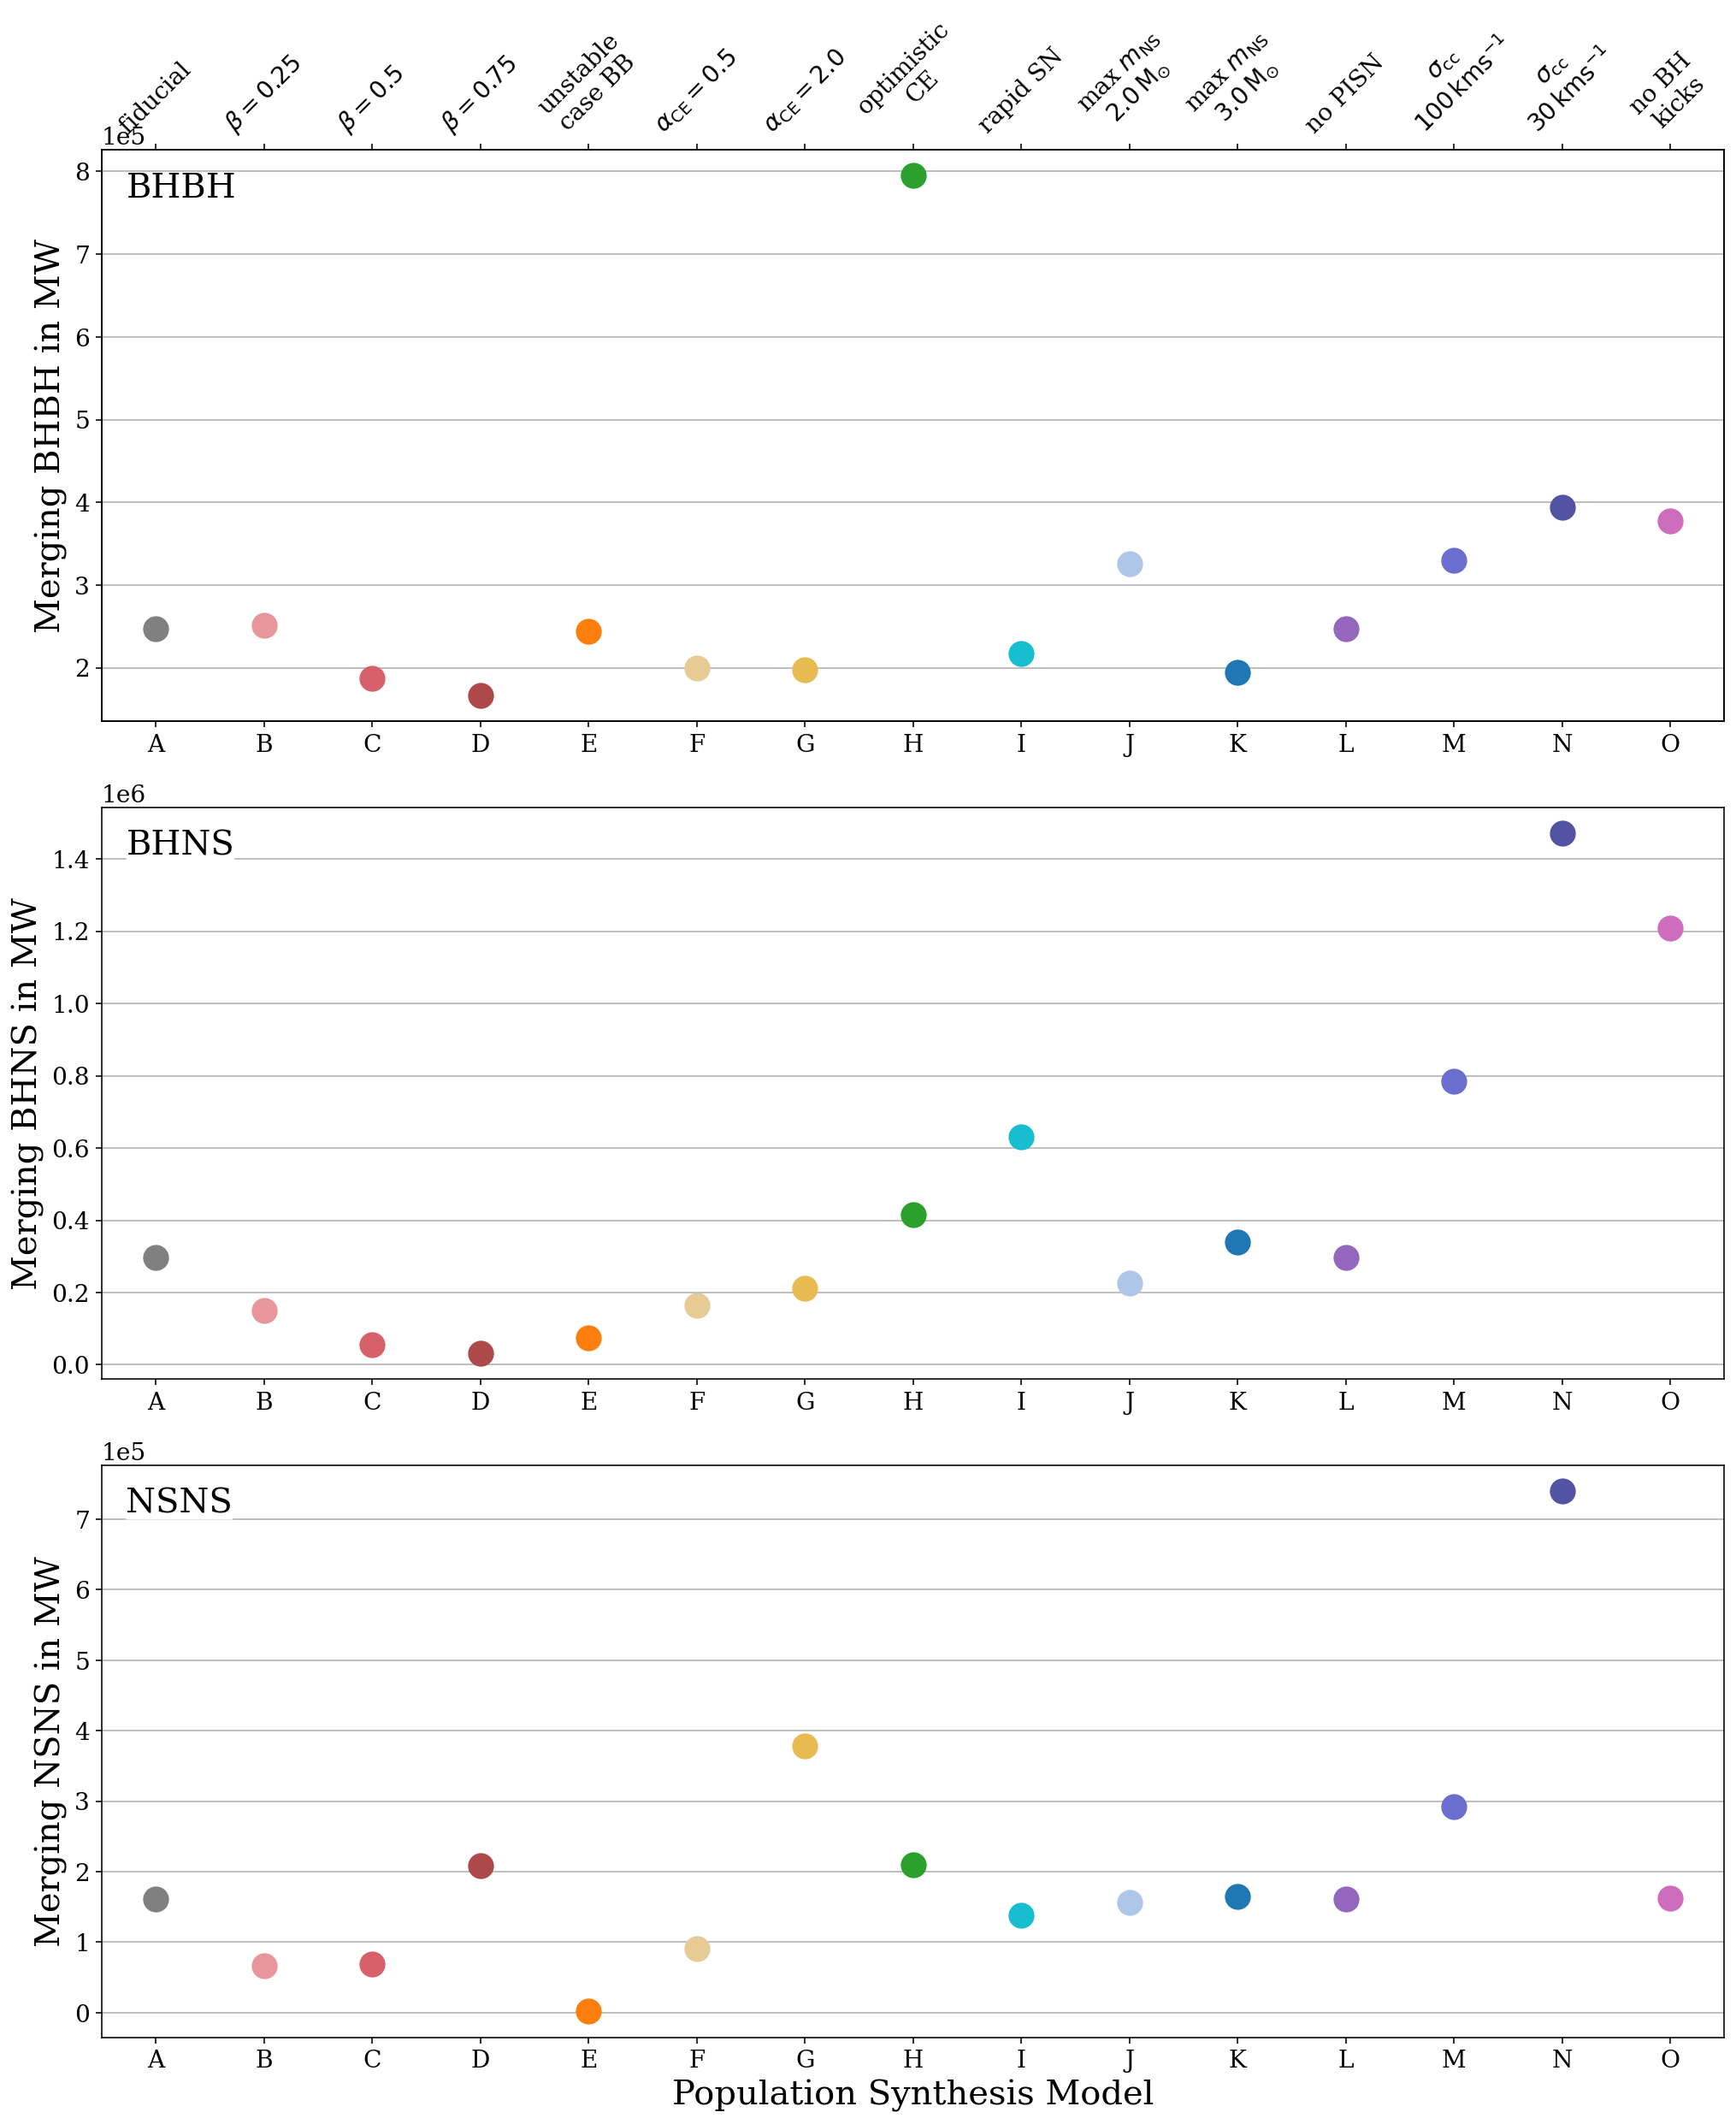

In [17]:
fig, axes = plt.subplots(3, figsize=(17, 20.3))
fig.subplots_adjust(hspace=0.15)

for i in range(len(axes)):
    xticks = range(len(variations))
    colours = np.array([variations[v]["colour"] for v in range(len(variations))], dtype="object")
    
    for j in range(len(xticks)):
        axes[i].scatter(xticks[j], total_DCOs_in_MW[i][j] * 1.5, color=colours[j], s=200, zorder=10)
    
    ax = axes[i]
    
    ax.set_xticks(xticks)
    ax.set_xticklabels([variations[v]["short"] for v in range(len(variations))])
    ax.annotate(dco_types[i], xy=(0.015, 1 - 0.04), xycoords="axes fraction", fontsize=fs, va="top",
                bbox=dict(boxstyle="round", fc="white", ec="none", pad=0.0))

    ax.set_xlim(xticks[0] - 0.5, xticks[-1] + 0.5)
    ax.set_ylabel("Merging {} in MW".format(dco_types[i]))
    
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

    ax.grid(axis="y", which="major")
    
topax = axes[0].twiny()
topax.set_xticks(axes[0].get_xticks())
topax.set_xlim(axes[0].get_xlim())
topax.set_xticklabels([variations[v]["med"] for v in range(len(variations))], rotation=45, fontsize=0.7*fs)

axes[-1].set_xlabel("Population Synthesis Model", fontsize=fs)

plt.savefig("../../paper/figures/dco_merging.pdf", format="pdf", bbox_inches="tight")
    
plt.show()

# Table

In [54]:
for i in range(len(variations)):
    table_line = variations[i]["short"]
    for detection in [detections_4yr, detections_10yr]:
        for j in range(len(detection)):
            median = np.median(detection[j][i])
            five, ninefive = np.percentile(detection[j][i], [5, 95])
            lower = median - five
            upper = ninefive - median
            table_line += r" & \confinv{" + "{:.1f}".format(median) + "}{" \
                        + "{:.1f}".format(lower) + "}{" \
                        + "{:.1f}".format(upper) + "}"
    table_line += "\\\\"
    print(table_line)

A & \confinv{34.5}{21.0}{46.7} & \confinv{30.0}{20.1}{47.5} & \confinv{7.8}{5.0}{10.4} & \confinv{58.8}{31.0}{53.4} & \confinv{52.0}{28.1}{95.2} & \confinv{13.1}{6.8}{14.3}\\
B & \confinv{34.0}{19.8}{36.6} & \confinv{15.6}{9.6}{19.7} & \confinv{2.8}{1.9}{4.3} & \confinv{55.8}{27.8}{46.0} & \confinv{26.8}{13.8}{23.7} & \confinv{4.8}{2.7}{5.6}\\
C & \confinv{20.6}{11.1}{20.6} & \confinv{5.3}{3.0}{5.3} & \confinv{4.3}{3.1}{5.2} & \confinv{33.8}{15.8}{26.8} & \confinv{8.9}{4.2}{7.0} & \confinv{7.3}{4.5}{6.2}\\
D & \confinv{22.0}{14.7}{37.9} & \confinv{4.1}{2.6}{4.2} & \confinv{11.6}{8.3}{22.7} & \confinv{36.1}{21.6}{45.5} & \confinv{6.8}{3.4}{5.3} & \confinv{20.6}{12.7}{27.8}\\
E & \confinv{33.8}{19.5}{37.1} & \confinv{3.3}{2.3}{6.3} & \confinv{0.2}{0.1}{0.1} & \confinv{55.0}{26.8}{44.3} & \confinv{5.9}{3.5}{8.2} & \confinv{0.3}{0.1}{0.2}\\
F & \confinv{26.3}{16.1}{35.9} & \confinv{15.1}{11.5}{84.2} & \confinv{5.7}{3.8}{7.4} & \confinv{43.5}{22.3}{43.8} & \confinv{27.3}{18.3}{86.5} & \conf